In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import gc


### Big Data Import

import with minimal datatypes, and only desired columns (leave out attributed time in the training set)

In [3]:
train_cols = ['ip','app','device','os','channel','click_time','is_attributed']
test_cols = ['ip','app','device','os','channel','click_time','click_id']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32',
        'is_attributed' : 'uint8'     # Don't import attributed_time-- not sure how it will help us in training since it isn't in test.
        }
original_df = pd.read_csv('train.csv', usecols= train_cols, dtype = dtypes)
test_df = pd.read_csv('test.csv') 


In [9]:
pd.to_datetime(original_df.click_time).dt.day.value_counts()

7    10691427
6     9308565
9     6877332
Name: click_time, dtype: int64

In [ ]:
original_df

In [3]:
original_df.shape

(26877324, 7)

In [4]:
original_df.is_attributed.value_counts()[1]/ original_df.is_attributed.value_counts()[0]

0.0024196224082187498

As we saw in the EDA, our labels are imbalanced. To create a better training dataset, we will take all of the 1's from the original dataframe, and all of the 0's from the sample dataframe given to us (to keep a random distributioin of the 0's)

In [5]:
from sklearn.model_selection import train_test_split
y = original_df.is_attributed
X = original_df.iloc[:,:-1]

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.33, random_state=42)

In [6]:
del original_df, X, y
gc.collect()

21

In [7]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

y_res.value_counts()

0    43237
1    43237
Name: is_attributed, dtype: int64

In [8]:
del X_train, y_train
gc.collect()

21

### Feature Engineering

To create meaningful features out of datetime given to us, we will split them up into day, hour, minutes, and seconds 

###### (the days should be converted from numbers to weekdays-- haven't done this yet)

Then, we create a series of groupby's and merges to attempt to create more meaningful features.

In [9]:
def pre_process(X): 
    X.click_time = pd.to_datetime(X.click_time, dayfirst = True)
    # d = X.set_index('click_time')
    X['day'] = X['click_time'].dt.day.astype('uint8')
    X['hour'] = X['click_time'].dt.hour.astype('uint8')
    X['min'] = X['click_time'].dt.minute.astype('uint8')
    X['sec'] = X['click_time'].dt.second.astype('uint8')

    gb = X.groupby(['ip','day', 'hour'])[['channel']].count().reset_index().rename(index = str, columns= {'channel' : 'ip_day_hour_count'})
    df = X.merge(gb, on=['ip','day','hour'], how='left' )

    del gb
    gc.collect()

    gb = X.groupby(['ip','app', 'os'])[['channel']].count().reset_index().rename(index = str, columns= {'channel' : 'ip_app_os_count'})
    df = df.merge(gb, on=['ip','app','os'], how='left' )

    del gb
    gc.collect()

    gb = X.groupby(['ip','app', 'device'])[['channel']].count().reset_index().rename(index = str, columns= {'channel' : 'ip_app_device_count'})
    df = df.merge(gb, on=['ip','app','device'], how='left' )

    del gb
    gc.collect()
    gb = X.groupby(['ip','channel', 'device'])[['app']].count().reset_index().rename(index = str, columns= {'app' : 'ip_channel_device_count'})
    df = df.merge(gb, on=['ip','channel','device'], how='left' )

    del gb
    gc.collect()
    gb = X.groupby(['ip','channel', 'os'])[['app']].count().reset_index().rename(index = str, columns= {'app' : 'ip_channel_os_count'})
    df = df.merge(gb, on=['ip','channel', 'os'], how='left' )
    return df

In [10]:
X_res = pre_process(X_res)

We need to drop click_time, as it is date time. 

Should also consider dropping IP, because it will be mistaken as continuos data (haven't done this yet)

In [11]:
X_res.drop(['click_time'], axis = 1, inplace =True)

In [12]:
X_res

,ip,app,device,os,channel,day,hour,min,sec,ip_day_hour_count,ip_app_os_count,ip_app_device_count,ip_channel_device_count,ip_channel_os_count
0,169280,9,1,19,442,6,16,54,14,1,1,1,1,1
1,186794,11,1,19,481,6,23,27,44,2,1,1,1,1
2,132480,3,1,19,205,6,21,11,57,2,1,1,1,1
3,44433,3,1,13,452,6,23,51,15,1,1,1,1,1
4,20362,3,1,19,115,7,0,2,22,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86469,148942,29,1,20,213,7,0,28,30,1,1,1,1,1
86470,143318,84,0,21,101,7,3,54,37,1,1,1,1,1
86471,40436,35,1,19,21,7,1,53,5,1,1,1,1,1
86472,197415,11,2,22,487,6,22,59,9,2,1,1,1,1


In [13]:
X_val = pre_process(X_val)
X_val.drop('click_time', axis = 1, inplace = True)

### Modeling

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [60]:
parameters = { 'n_estimators': [100,300,500,1000], 'max_depth': [None, 10, 20, 50], }
RFclf = GridSearchCV(RandomForestClassifier(), param_grid= parameters, cv = 3, scoring= 'roc_auc', n_jobs = -1, verbose = 10)
RFclf.fit(X_res, y_res)

print(RFclf.best_params_)
# print(RFclf.score(X_val, y_val))
# rf = RandomForestClassifier(**RFclf.best_params_, oob_score= True)
# rf.fit(x_train, y_train)
# rf.oob_score_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
best_rf = RFclf.best_estimator_
best_rf.fit(X_res, y_res)

roc_auc_score(y_val, best_rf.predict_proba(X_val)[:, 1])

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


True


0.9914211970065641

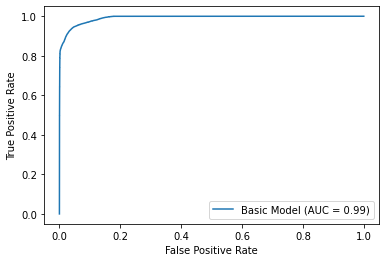

In [ ]:
# RocCurveDisplay.from_predictions(y, scores) # Directly from preds
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
y_pred = rf.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Basic Model') 
display.plot()
plt.show()

In [1]:
fpr

NameError: name 'fpr' is not defined

In [ ]:
from xgboost import XGBRegressor
parameters = { 'n_estimators': [100, 200,250], 'max_depth': [5, 10, 15,  20]}
XGBclf = GridSearchCV(XGBRegressor(), param_grid= parameters, cv = 3, scoring= 'roc_auc', n_jobs = -1, verbose = 10)
XGBclf.fit(x_train, y_train)

print(XGBclf.best_params_)
print(XGBclf.score(x_val, y_val)) 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[20:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 5, 'n_estimators': 250}
0.9942609324178306


In [ ]:
xgb = RandomForestClassifier(**XGBclf.best_params_)
xgb.fit(x_train, y_train)
roc_auc_score(y_val, rf.predict_proba(x_val)[:, 1])

0.9944152408906743

### Export Predictions

In [ ]:
test_df = pd.read_csv('test.csv') 
test_x = pre_process(test_df)
test_x.drop(['click_id', 'click_time'], axis = 1, inplace =True)

In [ ]:
test_pred = rf.predict_proba(test_x)[:, 1]

In [ ]:
test_pred

array([0.  , 0.01, 0.12, ..., 0.73, 0.99, 0.03])

In [ ]:
Id = test_df['click_id']

In [ ]:
del test_df
gc.collect()

171

In [ ]:
sub = pd.DataFrame({'Id': np.array(Id), 'Expected': test_pred})
# sub.columns = ['Id', 'Expected']
sub.Id = sub.Id.astype('Int64')
# sub.set_index('Id',inplace= True)

In [ ]:
sub

,Id,Expected
0,2010044773365,0.27
1,2010044773366,0.26
2,2010044773367,0.11
3,2010044773368,0.46
4,2010044773369,0.17
...,...,...
3026553,2542620653135,0.09
3026554,2542620653136,0.13
3026555,2542620653137,0.18
3026556,2542620653138,0.10


In [ ]:
pd.DataFrame.to_csv(sub, 'submission', index = False)